In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=992548a92e26e2837312b40b2ffa153880af4424a07e4c154b6704d1619d2d17
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


# New Section

In [0]:
path = '/content/drive/My Drive/nCov19'

In [4]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19,VGG16,ResNet50
from tensorflow.keras.layers import AveragePooling2D, SeparableConv2D, Dropout, Flatten, Dense, Input, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

In [0]:
def show_image(img):
    plt.imshow(img, cmap = 'gray')
    plt.title('Example X-Ray Scan')
    plt.grid(False)
    plt.axis('off')
    plt.show()

def plot_cm(labels, predictions):
    print(classification_report(labels, predictions,target_names=lb.classes_))

    cm = confusion_matrix(labels, predictions)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0]+ cm[1, 1])
    
    print("accuracy: {:.3f}".format(acc))
    print("sensitivity: {:.3f}".format(sensitivity))
    print("specificity: {:.3f}".format(specificity))
    print()
    print('Correct Healthy Patient Detection (True Negatives): ', cm[0][0])
    print('Incorrect Covid-19 Detection (False Positives): ', cm[0][1])
    print('Incorrect Healthy Patient Detection (False Negatives): ', cm[1][0])
    print('Correct Covid-19 Detection (True Positives): ', cm[1][1])
    print('Total Patients with Covid-19: ', np.sum(cm[1]))

    print()
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [7]:
df = pd.read_csv(f'{path}/metadata.csv')
df.head()

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


[IN] Loading images...
/content/drive/My Drive/nCov19/DATASET/COVID/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
COVID
(1482, 1989, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S0929664620300449-gr2_lrg-a.jpg
COVID
(1163, 1165, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S0929664620300449-gr2_lrg-b.jpg
COVID
(1161, 1170, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S1684118220300608-main.pdf-001.jpg
COVID
(411, 477, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S0929664620300449-gr2_lrg-c.jpg
COVID
(1165, 1165, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S0140673620303706-fx1_lrg.jpg
COVID
(1148, 2563, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S1684118220300608-main.pdf-002.jpg
COVID
(500, 508, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S1684118220300682-main.pdf-002-a1.png
COVID
(362, 439, 3)
/content/drive/My Drive/nCov19/DATASET/COVID/1-s2.0-S1684118220300682-main.pdf-003-b1.png
COVID
(391, 436, 3)
/content/dri

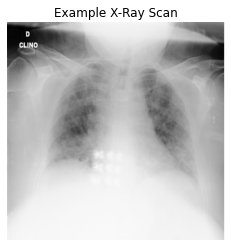

Example scan label:	  COVID
One-hot encoded label:  [1. 0.]


In [20]:
# Initialize the variables for training
dataset_path = f'{path}/DATASET'
init_lr = 2e-3
epochs = 100
batch_size = 5

print("[IN] Loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels_ = []

# loop over the image paths
for imagePath in imagePaths:
    print(imagePath)
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    print(label)
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    img = cv2.resize(img, (512, 512))

    # update the data and labels lists, respectively
    data.append(img)
    labels_.append(label)

# Normalize images to range [0,1]
data = np.array(data) / 255.0
labels_ = np.array(labels_)

# Plot example patient scan
print('Number of training images: ', len(data))
print()
show_image(data[0])

# perform one-hot encoding on the labels
print('Example scan label:\t ', labels_[0])
lb = LabelBinarizer()
labels = lb.fit_transform(labels_)
labels = to_categorical(labels)
print('One-hot encoded label: ', labels[0])

In [52]:
# split training and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42, shuffle=True)

(trainX, validX, trainY, validY) = train_test_split(trainX, trainY,
	test_size=0.20, stratify=trainY, random_state=42, shuffle=True)

print('Number of training pairs: ', len(trainX))
print('Number of validation pairs: ', len(validX))
print('Number of testing pairs: ', len(testX))

# # initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=10,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	vertical_flip=True,
	fill_mode="nearest")

# Load the VGG19 network
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(512, 512, 3)))

# Make all pre-trained layers from VGG19 non-trainable 
for layer in baseModel.layers[:-3]:
    layer.trainable = False

# Add trainable fully-connected (FC) layers for predictions
newModel = baseModel.output
newModel = AveragePooling2D(pool_size=(4, 4))(newModel)
newModel = Flatten(name="flatten")(newModel)
newModel = Dense(48, activation="relu")(newModel)
newModel = Dropout(0.5)(newModel)
newModel = Dense(2, activation="softmax")(newModel)

# Stack the FC layers on top of VGG19 model
model = Model(inputs=baseModel.input, outputs=newModel, name='nCov19_Detector')

# compile our model
print("\n[INFO] compiling model...")
opt = Adam(lr=init_lr,decay=init_lr/epochs)
model.compile(loss="hinge", optimizer=opt, metrics=["accuracy"])


Number of training pairs:  90
Number of validation pairs:  23
Number of testing pairs:  29

[INFO] compiling model...


In [53]:
idx = np.random.randint(0,len(data))
print('idx: ', idx)
print()
print(labels_[idx])
print(labels[idx])

idx:  102

NORMAL
[0. 1.]


In [54]:
class_weights = {0 : 1, 1 : 2.01}
e_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=12,
    mode='max',
    restore_best_weights=True)

# train the model
print("[IN] Training new model ...")
results = model.fit_generator(
	trainAug.flow(trainX, trainY),
	validation_data=(validX, validY),
    callbacks = [e_stopping],
	epochs=epochs,
    )

[IN] Training new model ...
  ...
    to  
  ['...']
Train for 3 steps, validate on 23 samples
Epoch 1/85
3/3 [==============================] - 6s 2s/step - loss: 1.0496 - accuracy: 0.4222 - val_loss: 0.9333 - val_accuracy: 0.5217
Epoch 2/85
3/3 [==============================] - 5s 2s/step - loss: 1.0189 - accuracy: 0.4778 - val_loss: 1.0205 - val_accuracy: 0.4783
Epoch 3/85
3/3 [==============================] - 5s 2s/step - loss: 0.9545 - accuracy: 0.5556 - val_loss: 0.6434 - val_accuracy: 0.8696
Epoch 4/85
3/3 [==============================] - 5s 2s/step - loss: 0.9033 - accuracy: 0.5889 - val_loss: 0.5902 - val_accuracy: 0.9130
Epoch 5/85
3/3 [==============================] - 5s 2s/step - loss: 0.7070 - accuracy: 0.7889 - val_loss: 0.7083 - val_accuracy: 0.7826
Epoch 6/85
3/3 [==============================] - 5s 2s/step - loss: 0.6277 - accuracy: 0.8667 - val_loss: 0.6718 - val_accuracy: 0.8261
Epoch 7/85
3/3 [==============================] - 5s 2s/step - loss: 0.6812 - accur

In [55]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)
print('\nNumber of test scans: ', len(testX))
print('Predicted class probabilities:')
print(predIdxs)

# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome (Covid=1, Normal=0):')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)

[INFO] evaluating network...

Number of test scans:  29
Predicted class probabilities:
[[1.0000000e+00 4.0227835e-10]
 [2.1910320e-05 9.9997807e-01]
 [9.9999988e-01 6.4635955e-08]
 [9.9186277e-01 8.1372373e-03]
 [1.0000000e+00 1.7757029e-14]
 [4.9824877e-17 1.0000000e+00]
 [1.0000000e+00 5.0654246e-12]
 [1.0000000e+00 6.9641957e-12]
 [9.9989522e-01 1.0477492e-04]
 [5.1219945e-32 1.0000000e+00]
 [4.1734283e-11 1.0000000e+00]
 [2.2862791e-01 7.7137208e-01]
 [5.2879409e-07 9.9999952e-01]
 [2.6015729e-14 1.0000000e+00]
 [4.9824877e-17 1.0000000e+00]
 [1.0000000e+00 1.0348014e-09]
 [7.2532909e-33 1.0000000e+00]
 [1.0000000e+00 1.2118861e-13]
 [1.7876497e-02 9.8212355e-01]
 [1.2993140e-31 1.0000000e+00]
 [1.0000000e+00 1.2346005e-10]
 [5.1750451e-38 1.0000000e+00]
 [1.2869834e-36 1.0000000e+00]
 [1.0000000e+00 1.2712519e-14]
 [1.0000000e+00 5.4908763e-13]
 [1.0000000e+00 3.2547074e-13]
 [1.0000000e+00 1.3652845e-12]
 [1.0000000e+00 4.5529865e-11]
 [9.9986899e-01 1.3097671e-04]]

Predicted ou

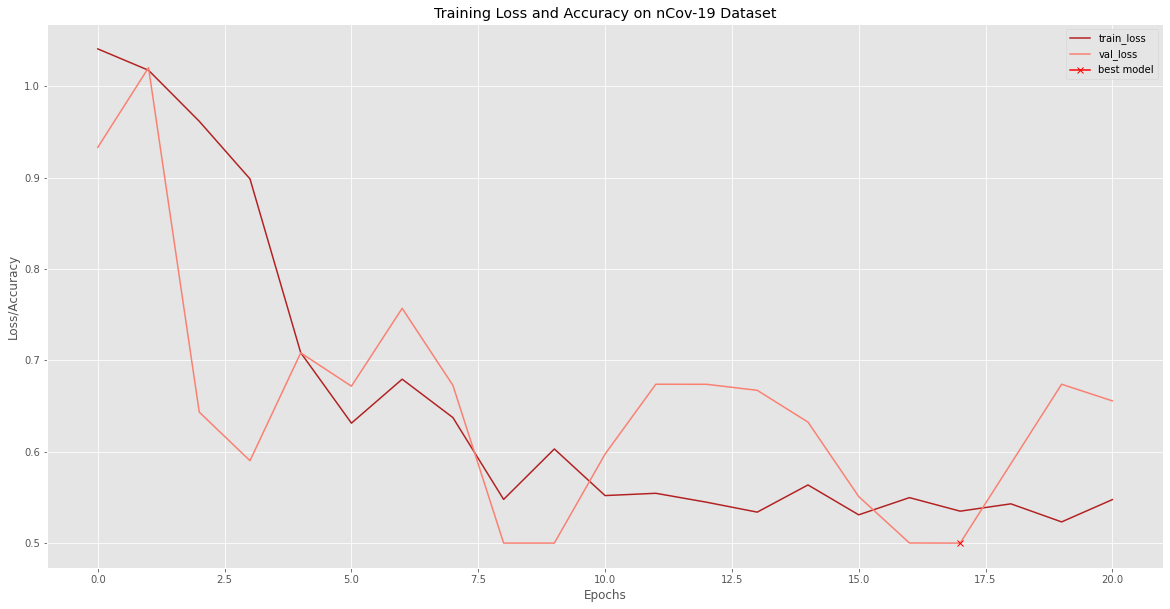

In [59]:
N = len(results.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss", color = 'salmon')
#plt.plot(np.arange(0, N), results.history["accuracy"], label="train_acc", color = 'teal')
#plt.plot(np.arange(0, N), results.history["val_accuracy"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on nCov-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('loss_curve.pdf', format='pdf')
plt.show()


loss :  0.577186761231258
accuracy :  0.9310345

              precision    recall  f1-score   support

       COVID       0.88      1.00      0.93        14
      NORMAL       1.00      0.87      0.93        15

    accuracy                           0.93        29
   macro avg       0.94      0.93      0.93        29
weighted avg       0.94      0.93      0.93        29

accuracy: 0.931
sensitivity: 1.000
specificity: 0.867

Correct Healthy Patient Detection (True Negatives):  14
Incorrect Covid-19 Detection (False Positives):  0
Incorrect Healthy Patient Detection (False Negatives):  2
Correct Covid-19 Detection (True Positives):  13
Total Patients with Covid-19:  15



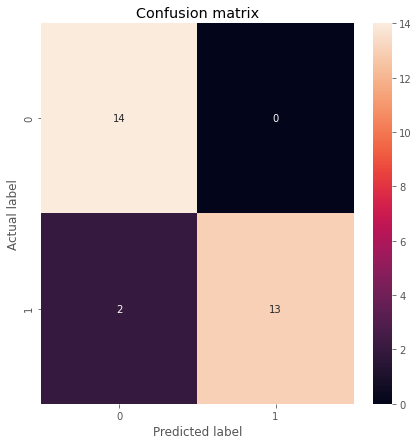

In [60]:
predicted_metrics = model.evaluate(testX, testY,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

plot_cm(trueIdxs, predIdxs)
plt.savefig('confusion_matrix.pdf', format='pdf')